In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
import datetime

# Later, for ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklearn below, this keeps them 
# out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [2]:
def update_calendar(cutoff):
    calendar_update = calendar.iloc[:cutoff, :]
    calendar_dates = calendar_update[['date', 'd']]
    calendar_dates = calendar_dates.set_index('d')
    return calendar_dates

def drop_christmas(series):
    df = calendar[['date', 'd']]
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df['month'] = df.index.month
    df['day'] = df.index.day
    month_mask = df['month'] == 12
    day_mask = df['day'] == 25
    df = df[month_mask & day_mask]
    df = df.drop(columns = ['month', 'day'])
    df['date'] = df.index
    df = df.set_index('d')
    lst = df.index.tolist()
    return series.drop(index = lst)

def make_date_time(Series):
    df = pd.DataFrame(Series)
    df1 = df.join(calendar_updates)
    df1['date'] = pd.to_datetime(df1['date'])
    df1 = df1.set_index('date')
    return df1

#To make a graph with a linear trendline
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series, label = 'Sales')
    ax.set_title(name)
    ax.legend()
    
def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend, label = 'Trend')
    ax.legend()
    
# To make a detrended graph
def detrended_graph(Series):
    python_series = Series
    python_linear_trend = fit_linear_trend(python_series)
    python_series_detrended = python_series - python_linear_trend

    fig, ax = plt.subplots(1, figsize=(14, 2))
    ax.plot(python_series_detrended.index, python_series_detrended)
    ax.set_title("Walmart Total Food Sales Detrended")
    plt.tight_layout()
    
def fit_moving_average_trend(series, window=6):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)
    
def create_monthly_dummies(series):
    i = series.index.interval
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(i).iloc[:, :11]

def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def plot_seasonal_trend(ax, name, series, interval='month'):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, seasons_average_trend)

def deseasonalize(Series):
    series = Series.iloc[:, 0]
    seasonal_trend = fit_seasonal_trend(Series)
    easonal_detrended = series - seasonal_trend

    fig, ax = plt.subplots(1, figsize=(14, 2))
    ax.plot(Series.index, _seasonal_detrended)
    ax.set_title(f'Walmart {list(Series)[0]} Sales, Deseasonalized')
    
def resample_series(series, interval):
    df = series.resample(interval).sum()
    df = df.iloc[1:, :]
    df = df.iloc[:-1, :]
    return df

def plot_seasonal_decomposition(axs, series):
    sd = sm.tsa.seasonal_decompose(series)
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[0].set_ylabel('Sales')
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[1].set_ylabel('Sales')
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[2].set_ylabel('Sales')
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")
    axs[3].set_xlabel('Time')
    axs[3].set_ylabel('Sales')
    
def make_forecast(series, interval, num_of_test_periods, forecast_period, forecast_month):
    '''
    Forecast Sales at Given Interval for a Given Series. Can be used to train, or to predict unseen data.
    
    Params:
    Series- Series that you want to forecast
    Interval- 'Q, M, W, d'
    num_of_test_periods- For example, if you enter '2' it will take your 'monthly' forecast
                         and will leave off the latest 2 periods so you can test against it for accuracy
    forecast_period- Can be up to the num_of_test_periods. If you leave off 2 months, you can forecast/predict
                     the first or the second month
    forecast_month-  If your forecast period is 1 and you are forecasting into february, you need to put a 2
                     so the seasonality for that month can be added in
    
    Returns:
    forecast- The projected units sold for that specific series
    error- will give you the error for what percent your forecast differs from actuals
    '''
    df = resample_series(series, interval)
    train_series = df[:-num_of_test_periods]
    X = make_design_matrix(np.arange(len(train_series)) + 1)
    linear_trend_ols = sm.OLS(train_series.values, X).fit()
    slope_intercept = linear_trend_ols.params
    slope = slope_intercept[0]
    intercept = slope_intercept[1]
    trend = slope*(len(train_series) + forecast_period) + intercept
    sd = sm.tsa.seasonal_decompose(df)
    seasonal_pattern = sd.seasonal[11:23]
    seasonal = seasonal_pattern.loc[seasonal_pattern.index.month == forecast_month].iloc[0, 0]
    forecast = trend + seasonal
    actual = df[-num_of_test_periods:].loc[df[-num_of_test_periods:].index.month == forecast_month].iloc[0, 0]
    error = (forecast-actual)/actual
    return forecast, error, actual, train_series

def trickle_down_forecast(upper_forecast, actual, path_lst):
    forecast = upper_forecast * np.prod(path_lst)
    if actual == None:
        return forecast
    else:
        error = (forecast - actual)/actual
        return forecast, error
    
def naive_monthly_distribution(store, department, product_id, lst_of_years, month_num):
    lst=[]
    newDF = pd.DataFrame()
    mask1 = sales_train['store_id'] == store
    mask2 = sales_train['dept_id'] == department
    df = sales_train[mask1 & mask2].copy()
    df = df.drop(columns = ['item_id', 'dept_id', 'store_id', 'state_id', 'cat_id'])
    df = df.set_index('id')
    df = df.loc[[product_id]]
    df = df.T
    df = make_date_time(df)
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_week'] = df.index.dayofweek
    df = df[df['month'] == month_num]
    for year in lst_of_years:
        df1 = df.copy()
        df1 = df1[df1['year'] == year]
        df1.loc['TOTAL']= df1.iloc[:, 0].sum()
        df1[f'{list(df1)[0]}_percent'] = df[list(df1)[0]] / df1.iloc[-1:, 0][0]
        lst.append(pd.DataFrame(list(df1[list(df1)].iloc[:, -1][:-1])))
    newDF = pd.concat(lst, ignore_index=True, axis=1)
    newDF['average'] = newDF.mean(numeric_only=True, axis=1)
    newDF.loc['TOTAL']= newDF.sum()
    if month_num == 2:
        check = newDF.iloc[-1, -1] - 1
        if check > 0:
            newDF.iloc[-2, -1] = newDF.iloc[-2, -1] - check
            newDF.iloc[-1, -1] = newDF.iloc[-1, -1] - check
    return newDF

class graphs():
    
    def __init__(self, series, interval, name):
        self.series = series
        self.interval = interval
        self.name = name

    def TSR(self):
        fig, axs = plt.subplots(4, figsize=(14, 8))
        plot_seasonal_decomposition(axs, resample_series(self.series, self.interval))
        fig.suptitle(self.name, y=1.05, x=.525, fontsize = 20)
        plt.tight_layout()
        
    def linear_trend(self):
        fig, ax = plt.subplots(1, figsize=(14, 12))
        plot_linear_trend(ax, self.name, resample_series(self.series, self.interval))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')
        ax.legend()
        plt.tight_layout()

In [3]:
sales_train = pd.read_csv('../data/sales_train_validation.csv')
sell_prices = pd.read_csv('../data/sell_prices.csv')
calendar = pd.read_csv('../data/calendar.csv')

calendar_updates = update_calendar(1913)

sales_train_cat = sales_train.groupby(['cat_id']).sum()
sales_train_cat_food = sales_train_cat.iloc[0, :].T
sales_train_cat_hobbies = sales_train_cat.iloc[1, :].T
sales_train_cat_household = sales_train_cat.iloc[2, :].T

sales_train_cat.loc['TOTAL']= sales_train_cat.sum()
sales_train_cat_all = sales_train_cat.iloc[3, :].T

sales_train_dept = sales_train.groupby(['dept_id']).sum()
sales_train_dept_food1 = sales_train_dept.iloc[0, :].T
sales_train_dept_food2 = sales_train_dept.iloc[1, :].T
sales_train_dept_food3 = sales_train_dept.iloc[2, :].T
sales_train_dept_hobbies1 = sales_train_dept.iloc[3, :].T
sales_train_dept_hobbies2 = sales_train_dept.iloc[4, :].T
sales_train_dept_household1 = sales_train_dept.iloc[5, :].T
sales_train_dept_household2 = sales_train_dept.iloc[6, :].T

sales_train_state = sales_train.groupby(['state_id']).sum()
sales_train_ca = sales_train_state.iloc[0, :].T
sales_train_tx = sales_train_state.iloc[1, :].T
sales_train_wi = sales_train_state.iloc[2, :].T

sales_train_store = sales_train.groupby(['store_id']).sum()
sales_train_ca1 = sales_train_store.iloc[0, :].T
sales_train_ca2 = sales_train_store.iloc[1, :].T
sales_train_ca3 = sales_train_store.iloc[2, :].T
sales_train_ca4 = sales_train_store.iloc[3, :].T
sales_train_tx1 = sales_train_store.iloc[4, :].T
sales_train_tx2 = sales_train_store.iloc[5, :].T
sales_train_tx3 = sales_train_store.iloc[6, :].T
sales_train_wi1 = sales_train_store.iloc[7, :].T
sales_train_wi2 = sales_train_store.iloc[8, :].T
sales_train_wi3 = sales_train_store.iloc[9, :].T

sales_train_cat_food = drop_christmas(sales_train_cat_food)
sales_train_cat_hobbies = drop_christmas(sales_train_cat_hobbies)
sales_train_cat_household = drop_christmas(sales_train_cat_household)

sales_train_cat_all = drop_christmas(sales_train_cat_all)

sales_train_dept_food1 = drop_christmas(sales_train_dept_food1)
sales_train_dept_food2 = drop_christmas(sales_train_dept_food2)
sales_train_dept_food3 = drop_christmas(sales_train_dept_food3)
sales_train_dept_hobbies1 = drop_christmas(sales_train_dept_hobbies1)
sales_train_dept_hobbies2 = drop_christmas(sales_train_dept_hobbies2)
sales_train_dept_household1 = drop_christmas(sales_train_dept_household1)
sales_train_dept_household2 = drop_christmas(sales_train_dept_household2)

sales_train_ca = drop_christmas(sales_train_ca)
sales_train_tx = drop_christmas(sales_train_tx)
sales_train_wi = drop_christmas(sales_train_wi)

sales_train_ca1 = drop_christmas(sales_train_ca1)
sales_train_ca2 = drop_christmas(sales_train_ca2)
sales_train_ca3 = drop_christmas(sales_train_ca3)
sales_train_ca4 = drop_christmas(sales_train_ca4)
sales_train_tx1 = drop_christmas(sales_train_tx1)
sales_train_tx2 = drop_christmas(sales_train_tx2)
sales_train_tx3 = drop_christmas(sales_train_tx3)
sales_train_wi1 = drop_christmas(sales_train_wi1)
sales_train_wi2 = drop_christmas(sales_train_wi2)
sales_train_wi3 = drop_christmas(sales_train_wi3)

big_food = make_date_time(sales_train_cat_food)
big_hobby = make_date_time(sales_train_cat_hobbies)
big_household = make_date_time(sales_train_cat_household)

big_all = make_date_time(sales_train_cat_all)

med_food1 = make_date_time(sales_train_dept_food1)
med_food2 = make_date_time(sales_train_dept_food2)
med_food3 = make_date_time(sales_train_dept_food3)
med_hobby1 = make_date_time(sales_train_dept_hobbies1)
med_hobby2 = make_date_time(sales_train_dept_hobbies2)
med_household1 = make_date_time(sales_train_dept_household1)
med_household2 = make_date_time(sales_train_dept_household2)

state_ca = make_date_time(sales_train_ca)
state_tx = make_date_time(sales_train_tx)
state_wi = make_date_time(sales_train_wi)

store_ca1 = make_date_time(sales_train_ca1)
store_ca2 = make_date_time(sales_train_ca2)
store_ca3 = make_date_time(sales_train_ca3)
store_ca4 = make_date_time(sales_train_ca4)
store_tx1 = make_date_time(sales_train_tx1)
store_tx2 = make_date_time(sales_train_tx2)
store_tx3 = make_date_time(sales_train_tx3)
store_wi1 = make_date_time(sales_train_wi1)
store_wi2 = make_date_time(sales_train_wi2)
store_wi3 = make_date_time(sales_train_wi3)

series_lst = [big_all, big_food, big_hobby, big_household,
              med_food1, med_food2, med_food3, med_hobby1, med_hobby2, med_household1, med_household2,
              state_ca, state_tx, state_wi,
              store_ca1, store_ca2, store_ca3, store_ca4, store_tx1, store_tx2, store_tx3, store_wi1, store_wi2, store_wi3
             ]

sales_all = sales_train_cat.T
sales_all = drop_christmas(sales_all)
sales_all = make_date_time(sales_all)
sales_all = resample_series(sales_all, 'M')
sales_all['foods_percent'] = sales_all['FOODS']/sales_all['TOTAL']
sales_all['hobbies_percent'] = sales_all['HOBBIES']/sales_all['TOTAL']
sales_all['household_percent'] = sales_all['HOUSEHOLD']/sales_all['TOTAL']

sales_dept_all = sales_train_dept.copy()
sales_dept_all.loc['TOTAL']= sales_dept_all.sum()
sales_dept_all = sales_dept_all.T
sales_dept_all = drop_christmas(sales_dept_all)
sales_dept_all = make_date_time(sales_dept_all)
sales_dept_all = resample_series(sales_dept_all, 'M')
sales_dept_all['foods1_percent'] = sales_dept_all['FOODS_1']/sales_dept_all['TOTAL']
sales_dept_all['foods2_percent'] = sales_dept_all['FOODS_2']/sales_dept_all['TOTAL']
sales_dept_all['foods3_percent'] = sales_dept_all['FOODS_3']/sales_dept_all['TOTAL']
sales_dept_all['hobbies1_percent'] = sales_dept_all['HOBBIES_1']/sales_dept_all['TOTAL']
sales_dept_all['hobbies2_percent'] = sales_dept_all['HOBBIES_2']/sales_dept_all['TOTAL']
sales_dept_all['household1_percent'] = sales_dept_all['HOUSEHOLD_1']/sales_dept_all['TOTAL']
sales_dept_all['household2_percent'] = sales_dept_all['HOUSEHOLD_2']/sales_dept_all['TOTAL']

sales_state_all = sales_train_state.copy()
sales_state_all.loc['TOTAL']= sales_state_all.sum()
sales_state_all = sales_state_all.T
sales_state_all = drop_christmas(sales_state_all)
sales_state_all = make_date_time(sales_state_all)
sales_state_all = resample_series(sales_state_all, 'M')
sales_state_all['ca_percent'] = sales_state_all['CA']/sales_state_all['TOTAL']
sales_state_all['tx_percent'] = sales_state_all['TX']/sales_state_all['TOTAL']
sales_state_all['wi_percent'] = sales_state_all['WI']/sales_state_all['TOTAL']

sales_store_all = sales_train_store.copy()
sales_store_all.loc['TOTAL']= sales_store_all.sum()
sales_store_all = sales_store_all.T
sales_store_all = drop_christmas(sales_store_all)
sales_store_all = make_date_time(sales_store_all)
sales_store_all = resample_series(sales_store_all, 'M')
sales_store_all['ca1_percent'] = sales_store_all['CA_1']/sales_store_all['TOTAL']
sales_store_all['ca2_percent'] = sales_store_all['CA_2']/sales_store_all['TOTAL']
sales_store_all['ca3_percent'] = sales_store_all['CA_3']/sales_store_all['TOTAL']
sales_store_all['ca4_percent'] = sales_store_all['CA_4']/sales_store_all['TOTAL']
sales_store_all['tx1_percent'] = sales_store_all['TX_1']/sales_store_all['TOTAL']
sales_store_all['tx2_percent'] = sales_store_all['TX_2']/sales_store_all['TOTAL']
sales_store_all['tx3_percent'] = sales_store_all['TX_3']/sales_store_all['TOTAL']
sales_store_all['wi1_percent'] = sales_store_all['WI_1']/sales_store_all['TOTAL']
sales_store_all['wi2_percent'] = sales_store_all['WI_2']/sales_store_all['TOTAL']
sales_store_all['wi3_percent'] = sales_store_all['WI_3']/sales_store_all['TOTAL']

sales_dept_food = sales_train_dept.iloc[:3, :].copy()
sales_dept_food.loc['TOTAL']= sales_dept_food.sum()
sales_dept_food = sales_dept_food.T
sales_dept_food = drop_christmas(sales_dept_food)
sales_dept_food = make_date_time(sales_dept_food)
sales_dept_food = resample_series(sales_dept_food, 'M')
sales_dept_food['foods1_percent'] = sales_dept_food['FOODS_1']/sales_dept_food['TOTAL']
sales_dept_food['foods2_percent'] = sales_dept_food['FOODS_2']/sales_dept_food['TOTAL']
sales_dept_food['foods3_percent'] = sales_dept_food['FOODS_3']/sales_dept_food['TOTAL']

sales_dept_hobby = sales_train_dept.iloc[3:5, :].copy()
sales_dept_hobby.loc['TOTAL']= sales_dept_hobby.sum()
sales_dept_hobby = sales_dept_hobby.T
sales_dept_hobby = drop_christmas(sales_dept_hobby)
sales_dept_hobby = make_date_time(sales_dept_hobby)
sales_dept_hobby = resample_series(sales_dept_hobby, 'M')
sales_dept_hobby['hobbies1_percent'] = sales_dept_hobby['HOBBIES_1']/sales_dept_hobby['TOTAL']
sales_dept_hobby['hobbies2_percent'] = sales_dept_hobby['HOBBIES_2']/sales_dept_hobby['TOTAL']

sales_dept_household = sales_train_dept.iloc[5:7, :].copy()
sales_dept_household.loc['TOTAL']= sales_dept_household.sum()
sales_dept_household = sales_dept_household.T
sales_dept_household = drop_christmas(sales_dept_household)
sales_dept_household = make_date_time(sales_dept_household)
sales_dept_household = resample_series(sales_dept_household, 'M')
sales_dept_household['household1_percent'] = sales_dept_household['HOUSEHOLD_1']/sales_dept_household['TOTAL']
sales_dept_household['household2_percent'] = sales_dept_household['HOUSEHOLD_2']/sales_dept_household['TOTAL']

sales_store_ca = sales_train_store.iloc[:4, :].copy()
sales_store_ca.loc['TOTAL']= sales_store_ca.sum()
sales_store_ca = sales_store_ca.T
sales_store_ca = drop_christmas(sales_store_ca)
sales_store_ca = make_date_time(sales_store_ca)
sales_store_ca = resample_series(sales_store_ca, 'M')
sales_store_ca['ca1_percent'] = sales_store_ca['CA_1']/sales_store_ca['TOTAL']
sales_store_ca['ca2_percent'] = sales_store_ca['CA_2']/sales_store_ca['TOTAL']
sales_store_ca['ca3_percent'] = sales_store_ca['CA_3']/sales_store_ca['TOTAL']
sales_store_ca['ca4_percent'] = sales_store_ca['CA_4']/sales_store_ca['TOTAL']


sales_store_tx = sales_train_store.iloc[4:7, :].copy()
sales_store_tx.loc['TOTAL']= sales_store_tx.sum()
sales_store_tx = sales_store_tx.T
sales_store_tx = drop_christmas(sales_store_tx)
sales_store_tx = make_date_time(sales_store_tx)
sales_store_tx = resample_series(sales_store_tx, 'M')
sales_store_tx['tx1_percent'] = sales_store_tx['TX_1']/sales_store_tx['TOTAL']
sales_store_tx['tx2_percent'] = sales_store_tx['TX_2']/sales_store_tx['TOTAL']
sales_store_tx['tx3_percent'] = sales_store_tx['TX_3']/sales_store_tx['TOTAL']

sales_store_wi = sales_train_store.iloc[7:10, :].copy()
sales_store_wi.loc['TOTAL']= sales_store_wi.sum()
sales_store_wi = sales_store_wi.T
sales_store_wi = drop_christmas(sales_store_wi)
sales_store_wi = make_date_time(sales_store_wi)
sales_store_wi = resample_series(sales_store_wi, 'M')
sales_store_wi['wi1_percent'] = sales_store_wi['WI_1']/sales_store_wi['TOTAL']
sales_store_wi['wi2_percent'] = sales_store_wi['WI_2']/sales_store_wi['TOTAL']
sales_store_wi['wi3_percent'] = sales_store_wi['WI_3']/sales_store_wi['TOTAL']

foods_mean = sales_all.iloc[:, 4].mean()
hobby_mean = sales_all.iloc[:, 5].mean()
household_mean =sales_all.iloc[:, 6].mean()
ca_mean = sales_state_all.iloc[:, 4].mean()
tx_mean = sales_state_all.iloc[:, 5].mean()
wi_mean = sales_state_all.iloc[:, 6].mean()
foods1_mean = sales_dept_food.iloc[:, 4].mean()
foods2_mean = sales_dept_food.iloc[:, 5].mean()
foods3_mean = sales_dept_food.iloc[:, 6].mean()
hobby1_mean = sales_dept_hobby.iloc[:, 3].mean()
hobby2_mean = sales_dept_hobby.iloc[:, 4].mean()
household1_mean = sales_dept_household.iloc[16:, 3].mean()
household2_mean = sales_dept_household.iloc[16:, 4].mean()
ca1_mean = sales_store_ca.iloc[:, 5].mean()
ca2_mean = sales_store_ca.iloc[:, 6].mean()
ca3_mean = sales_store_ca.iloc[:, 7].mean()
ca4_mean = sales_store_ca.iloc[:, 8].mean()
tx1_mean = sales_store_tx.iloc[40:, 4].mean()
tx2_mean = sales_store_tx.iloc[40:, 5].mean()
tx3_mean = sales_store_tx.iloc[40:, 6].mean()
wi1_mean = sales_store_wi.iloc[22:, 4].mean()
wi2_mean = sales_store_wi.iloc[22:, 5].mean()
wi3_mean = sales_store_wi.iloc[22:, 6].mean()

In [4]:
def make_series(store_id, dept_id):
    '''
    Use this function to make a series of the total sales for a specific store and department.
    The series is to be used for forecasting in the make_forecast function.
    '''
    mask1 = sales_train['store_id'] == store_id
    mask2 = sales_train['dept_id'] == dept_id
    series = sales_train[mask1 & mask2].copy()
    series = series.drop(columns = ['id', 'item_id', 'dept_id', 'store_id', 'state_id', 'cat_id'])
    series.loc['TOTAL']= series.sum()
    series = series.T
    series = drop_christmas(series)
    series = make_date_time(series)
    series = series['TOTAL'].to_frame()
    return series



#not going to add in the individual product id. Will be too complicated to forecast on the individual product.
#some products didn't start selling until recently. maybe will just go off a naive 2015 distribution.

In [5]:
make_series('CA_3', 'FOODS_3')

,TOTAL
date,
2011-01-29,2478
2011-01-30,2451
2011-01-31,1897
2011-02-01,2284
2011-02-02,1998
...,...
2016-04-20,2385
2016-04-21,2251
2016-04-22,2474


In [6]:
make_forecast(make_series('CA_3', 'FOODS_3'), 'M', 2, 1, 2)

(85647.08911252356, -0.0032343425950123383, 85925,              TOTAL
 date              
 2011-02-28   60302
 2011-03-31   63020
 2011-04-30   59716
 2011-05-31   57601
 2011-06-30   63093
 2011-07-31   66977
 2011-08-31   70539
 2011-09-30   72888
 2011-10-31   84355
 2011-11-30   75975
 2011-12-31   82911
 2012-01-31   84146
 2012-02-29   87227
 2012-03-31   98613
 2012-04-30   93309
 2012-05-31  101917
 2012-06-30  106706
 2012-07-31  105216
 2012-08-31  106816
 2012-09-30   94896
 2012-10-31   89303
 2012-11-30   77118
 2012-12-31   82363
 2013-01-31   84252
 2013-02-28   75127
 2013-03-31   86038
 2013-04-30   87876
 2013-05-31   88665
 2013-06-30  101641
 2013-07-31  105451
 2013-08-31  110488
 2013-09-30  108681
 2013-10-31  101718
 2013-11-30   92253
 2013-12-31   89124
 2014-01-31   94744
 2014-02-28   83774
 2014-03-31  100761
 2014-04-30  107231
 2014-05-31  105218
 2014-06-30  108718
 2014-07-31  113307
 2014-08-31  109543
 2014-09-30  103307
 2014-10-31   94382
 2014-11-3

In [7]:
make_forecast(make_series('CA_1', 'FOODS_3'), 'M', 2, 1, 2)

(60609.27608580509, 0.02326950559344076, 59231,             TOTAL
 date             
 2011-02-28  45566
 2011-03-31  47295
 2011-04-30  45519
 2011-05-31  42265
 2011-06-30  42695
 2011-07-31  46884
 2011-08-31  45714
 2011-09-30  45405
 2011-10-31  54062
 2011-11-30  53842
 2011-12-31  58772
 2012-01-31  56703
 2012-02-29  56721
 2012-03-31  66586
 2012-04-30  67926
 2012-05-31  73781
 2012-06-30  73127
 2012-07-31  69384
 2012-08-31  74396
 2012-09-30  67224
 2012-10-31  60514
 2012-11-30  56010
 2012-12-31  59623
 2013-01-31  55625
 2013-02-28  54026
 2013-03-31  62219
 2013-04-30  60306
 2013-05-31  64798
 2013-06-30  70970
 2013-07-31  74357
 2013-08-31  81033
 2013-09-30  79113
 2013-10-31  71323
 2013-11-30  66354
 2013-12-31  68015
 2014-01-31  66188
 2014-02-28  57457
 2014-03-31  68241
 2014-04-30  71244
 2014-05-31  69713
 2014-06-30  68888
 2014-07-31  74693
 2014-08-31  75914
 2014-09-30  68358
 2014-10-31  69959
 2014-11-30  66561
 2014-12-31  58335
 2015-01-31  64310
 20

In [8]:
# to do, can use this as a start to figure out yearly distribution and then 
#figure out how many salses go to an indivudal product
#only going to look at 2015 since some years had no sales

def monthly_product_distribution(store_id, dept_id):
    mask1 = sales_train['store_id'] == store_id
    mask2 = sales_train['dept_id'] == dept_id
    series = sales_train[mask1 & mask2].copy()
    series = series.drop(columns = ['item_id', 'dept_id', 'store_id', 'state_id', 'cat_id'])
    series = series.set_index('id')
    #series = series.loc[[product_id]]
    series = series.T
    series = make_date_time(series)
    series = resample_series(series, 'M')
    series = series.iloc[47:-3, :]
    series.loc['TOTAL']= series.sum()
    series = series.T
    series['jan_percent'] = series.iloc[:, 0] / series.iloc[:, 12]
    series['feb_percent'] = series.iloc[:, 1] / series.iloc[:, 12]
    series['mar_percent'] = series.iloc[:, 2] / series.iloc[:, 12]
    series['april_percent'] = series.iloc[:, 3] / series.iloc[:, 12]
    series['may_percent'] = series.iloc[:, 4] / series.iloc[:, 12]
    series['june_percent'] = series.iloc[:, 5] / series.iloc[:, 12]
    series['july_percent'] = series.iloc[:, 6] / series.iloc[:, 12]
    series['aug_percent'] = series.iloc[:, 7] / series.iloc[:, 12]
    series['sep_percent'] = series.iloc[:, 8] / series.iloc[:, 12]
    series['oct_percent'] = series.iloc[:, 9] / series.iloc[:, 12]
    series['nov_percent'] = series.iloc[:, 10] / series.iloc[:, 12]
    series['dec_percent'] = series.iloc[:, 11] / series.iloc[:, 12]
    #monthly_breakdown = series.iloc[:, -12:]
    total = series.iloc[:, 12].to_frame()
    total_sum = total.sum()[0]
    total['unit_percent'] = total['TOTAL']/total_sum
    #return monthly_breakdown, total, series
    return total

In [9]:
monthly_product_distribution('CA_1', 'FOODS_3')

,TOTAL,unit_percent
FOODS_3_001_CA_1_validation,114,0.000152
FOODS_3_002_CA_1_validation,797,0.001062
FOODS_3_003_CA_1_validation,320,0.000426
FOODS_3_004_CA_1_validation,407,0.000542
FOODS_3_005_CA_1_validation,204,0.000272
...,...,...
FOODS_3_823_CA_1_validation,491,0.000654
FOODS_3_824_CA_1_validation,78,0.000104
FOODS_3_825_CA_1_validation,353,0.000470
FOODS_3_826_CA_1_validation,356,0.000474


In [10]:
monthly_product_distribution('CA_1', 'FOODS_3')

,TOTAL,unit_percent
FOODS_3_001_CA_1_validation,114,0.000152
FOODS_3_002_CA_1_validation,797,0.001062
FOODS_3_003_CA_1_validation,320,0.000426
FOODS_3_004_CA_1_validation,407,0.000542
FOODS_3_005_CA_1_validation,204,0.000272
...,...,...
FOODS_3_823_CA_1_validation,491,0.000654
FOODS_3_824_CA_1_validation,78,0.000104
FOODS_3_825_CA_1_validation,353,0.000470
FOODS_3_826_CA_1_validation,356,0.000474


In [11]:
monthly_product_distribution('CA_1', 'FOODS_3')[2]

KeyError: 2

In [ ]:
mb = monthly_product_distribution('CA_1', 'FOODS_3')[0]
mb

In [12]:
mb.loc['FOODS_3_005_CA_1_validation'][1]

NameError: name 'mb' is not defined

In [13]:
total = monthly_product_distribution('CA_1', 'FOODS_3')[1]
total

KeyError: 1

In [14]:
total.loc['FOODS_3_005_CA_1_validation'][1]

NameError: name 'total' is not defined

In [15]:
df1 = naive_monthly_distribution('CA_1', 'FOODS_3', 'FOODS_3_005_CA_1_validation', [2011, 2012, 2013, 2014, 2015], 2)
df1

,0,1,2,3,4,average
0,0.1250,0.000000,0.033333,0.022222,0.1250,6.111111e-02
1,0.1250,0.073171,0.033333,0.044444,0.1250,8.018970e-02
2,0.0000,0.024390,0.033333,0.066667,0.1250,4.987805e-02
3,0.0625,0.048780,0.000000,0.022222,0.0000,2.670054e-02
4,0.0625,0.073171,0.100000,0.044444,0.0625,6.852304e-02
5,0.1875,0.024390,0.066667,0.044444,0.0000,6.460027e-02
6,0.0625,0.073171,0.066667,0.000000,0.0000,4.046748e-02
7,0.0625,0.000000,0.000000,0.022222,0.0625,2.944444e-02
8,0.0625,0.048780,0.000000,0.111111,0.0000,4.447832e-02
9,0.0625,0.048780,0.066667,0.000000,0.0625,4.808943e-02


In [16]:
def daily_distribution(store_dept_forecast, daily_series, store_id, dept_id, product_id, year, month):
    df = daily_series.iloc[:-1, -1].to_frame()
    df = df.fillna(0)
    df['year'] = year
    df['month'] = month
    if month == 2:
        if year %4 ==0:
            df['day'] = list(range(1,30))
        else:
            df = df.iloc[:-1, :]
            df['day'] = list(range(1,29))
    elif month == 1 or month == 3 or month == 5 or month == 7 or month == 8 or month == 10 or month == 12:
        df['day'] = range(1,32)
    else:
        df['day'] = range(1, 31)
    df['date'] = pd.to_datetime(df[["year", "month", "day"]])
    df.index = df['date']
    df = df.drop(columns = ['year', 'month', 'day', 'date'])
    #mb = monthly_product_distribution(store_id, dept_id)[0]
    total = monthly_product_distribution(store_id, dept_id)
    item_distribution = total.loc[product_id][1]
    #item_sold_in_month = mb.loc[product_id][month-1]
    #forecast_month_item = store_dept_forecast*item_distribution*item_sold_in_month
    forecast_month_item = store_dept_forecast*item_distribution
    df['forecast'] = df['average'] * forecast_month_item
    print(forecast_month_item)
    df = df['forecast'].to_frame()
    return df

In [17]:
forecast1 = make_forecast(make_series('CA_1', 'FOODS_3'), 'M', 2, 1, 2)[0]
df_test = daily_distribution(forecast1, df1, 'CA_1', 'FOODS_3', 'FOODS_3_005_CA_1_validation', 2016, 2)
df_test

16.471382012067146


,forecast
date,
2016-02-01,1.006584e+00
2016-02-02,1.320835e+00
2016-02-03,8.215604e-01
2016-02-04,4.397948e-01
2016-02-05,1.128669e+00
2016-02-06,1.064056e+00
2016-02-07,6.665553e-01
2016-02-08,4.849907e-01
2016-02-09,7.326194e-01


In [18]:
forecast1

60609.27608580509

In [19]:
forecast1 * .0784313 * .000272

1.2929966938074604

In [20]:
make_forecast(make_series('CA_1', 'FOODS_3'), 'M', 2, 1, 2)[2]

59231

In [21]:
resample_series(make_series('CA_1', 'FOODS_3'), 'M')

,TOTAL
date,
2011-02-28,45566
2011-03-31,47295
2011-04-30,45519
2011-05-31,42265
2011-06-30,42695
...,...
2015-11-30,55805
2015-12-31,52243
2016-01-31,59502


In [22]:
def get_product_actuals(store_id, dept_id, product_id, month, year):
    mask11 = sales_train['store_id'] == store_id
    mask21 = sales_train['dept_id'] == dept_id
    series1 = sales_train[mask11 & mask21].copy()
    series1 = series1.drop(columns = ['item_id', 'dept_id', 'store_id', 'state_id', 'cat_id'])
    series1 = series1.T
    series1 = drop_christmas(series1)
    series1 = make_date_time(series1)
    series1 = series1.T
    series1 = series1.set_index('NaT')
    series1 = series1.loc[product_id].to_frame()
    series1 = series1[series1.index.month == month]
    series1 = series1[series1.index.year == year]
    return series1

series1 = get_product_actuals('CA_1', 'FOODS_3', 'FOODS_3_005_CA_1_validation', 2, 2016)
series1

,FOODS_3_005_CA_1_validation
date,
2016-02-01,0
2016-02-02,0
2016-02-03,1
2016-02-04,3
2016-02-05,0
2016-02-06,2
2016-02-07,0
2016-02-08,0
2016-02-09,1


In [31]:
def actual_vs_forecast(actual_series, forecast_series):
    df = forecast_series.copy()
    df['actual'] = actual_series[list(actual_series)[0]]
    df['forecast'] = abs(df['forecast'].round(1))
    return df

def reg_round_comparison(df):
    df2 = df.round().copy()
    df2['year'] = df2.index.year
    df2['month'] = df2.index.month
    df2['day'] =  df2.index.day
    df2['date'] = pd.to_datetime(df2[["year", "month", "day"]])
    x = df2['date'].to_numpy().astype('datetime64[D]')
    y = x.tolist()
    y.append('Total')
    y = np.asarray(y)
    df2.loc['TOTAL']= df2.sum()
    df2['forecast'] = df2['forecast'].apply(np.int64)
    df2 = df2.set_index(y)
    df2 = df2.drop(columns = ['year', 'month', 'day', 'date'])
    return df2

df2 = actual_vs_forecast(series1, df_test)
x = reg_round_comparison(df2)
x

,forecast,actual
2016-02-01,1,0
2016-02-02,1,0
2016-02-03,1,1
2016-02-04,0,3
2016-02-05,1,0
2016-02-06,1,2
2016-02-07,1,0
2016-02-08,0,0
2016-02-09,1,1
2016-02-10,1,3


In [32]:
def no_rounding_comparison(df):
    df2 = df.copy()
    df2['year'] = df2.index.year
    df2['month'] = df2.index.month
    df2['day'] =  df2.index.day
    df2['date'] = pd.to_datetime(df2[["year", "month", "day"]])
    x = df2['date'].to_numpy().astype('datetime64[D]')
    y = x.tolist()
    y.append('Total')
    y = np.asarray(y)
    df2.loc['TOTAL']= df2.sum()
    df2 = df2.set_index(y)
    df2 = df2.drop(columns = ['year', 'month', 'day', 'date'])
    return df2

y = no_rounding_comparison(df2)
y

,forecast,actual
2016-02-01,1.0,0
2016-02-02,1.3,0
2016-02-03,0.8,1
2016-02-04,0.4,3
2016-02-05,1.1,0
2016-02-06,1.1,2
2016-02-07,0.7,0
2016-02-08,0.5,0
2016-02-09,0.7,1
2016-02-10,0.8,3


In [33]:
def manual_rounding_compy(df, round_up_decimal):
    df3 = df.copy()
    for i in range(len(df3)):
        if int(str(df3['forecast'][i])[-1:]) >= round_up_decimal:
            df3['forecast'][i] = np.ceil(df3['forecast'][i])
        else:
            df3['forecast'][i] = np.floor(df3['forecast'][i])
    df3['year'] = df3.index.year
    df3['month'] = df3.index.month
    df3['day'] =  df3.index.day
    df3['date'] = pd.to_datetime(df3[["year", "month", "day"]])
    x = df3['date'].to_numpy().astype('datetime64[D]')
    y = x.tolist()
    y.append('Total')
    y = np.asarray(y)
    df3.loc['Total']= df3.sum()
    df3['forecast'] = df3['forecast'].apply(np.int64)
    df3 = df3.set_index(y)
    #df3 = df3.fillna('Total')
    #df3['date2'] = str(df3['date'])
    #df3.iloc[-1: ,-1:] = 'Total'
    #df3.index[0:-1] = df3.index.date
    #df3['date'] = df3.apply(str)
    #df3.iloc[-1: ,-1:] = 'Total'
    #df3.iloc[:-1, -1:] = pd.DatetimeIndex(df3.date).normalize()
    #df3 = df.replace(np.nan, '', regex=True)
    #df3 = df3.set_index('date')
    #df3.index[-1] = 'Total'
    df3 = df3.drop(columns = ['year', 'month', 'day', 'date'])
    #df3 = df3.index.fillna("")
    #df3 = df3.rename(index={'NaT': 'Total'})
    #df3['date'] = df3.index
    #df3.iloc[:-1, -1:] = pd.DatetimeIndex(df3.date).normalize()
    #df3.index = df3.index.year.month.day
    #df3['year'] = df3.index.month
    return df3

z = manual_rounding_compy(df2, 4)
z

,forecast,actual
2016-02-01,1,0
2016-02-02,1,0
2016-02-03,1,1
2016-02-04,1,3
2016-02-05,1,0
2016-02-06,1,2
2016-02-07,1,0
2016-02-08,1,0
2016-02-09,1,1
2016-02-10,1,3


In [43]:
xxx = y.copy()
xxx['regular_rounding'] = x['forecast']
xxx['flexible_rounding'] = z['forecast']
cols = xxx.columns.tolist()
myorder = [0, 2, 3, 1]
cols = [cols[i] for i in myorder]
xxx = xxx[cols]
xxx

,forecast,regular_rounding,flexible_rounding,actual
2016-02-01,1.0,1,1,0
2016-02-02,1.3,1,1,0
2016-02-03,0.8,1,1,1
2016-02-04,0.4,0,1,3
2016-02-05,1.1,1,1,0
2016-02-06,1.1,1,1,2
2016-02-07,0.7,1,1,0
2016-02-08,0.5,0,1,0
2016-02-09,0.7,1,1,1
2016-02-10,0.8,1,1,3


In [26]:
x = manual_rounding_compy(df2, 4)['date'].to_numpy().astype('datetime64[D]')
y = x.tolist()
y.append('Total')
y

KeyError: 'date'

In [27]:
sales_train

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [28]:
a = graphs(big_all, 'M', 'Walmart Total Sales')

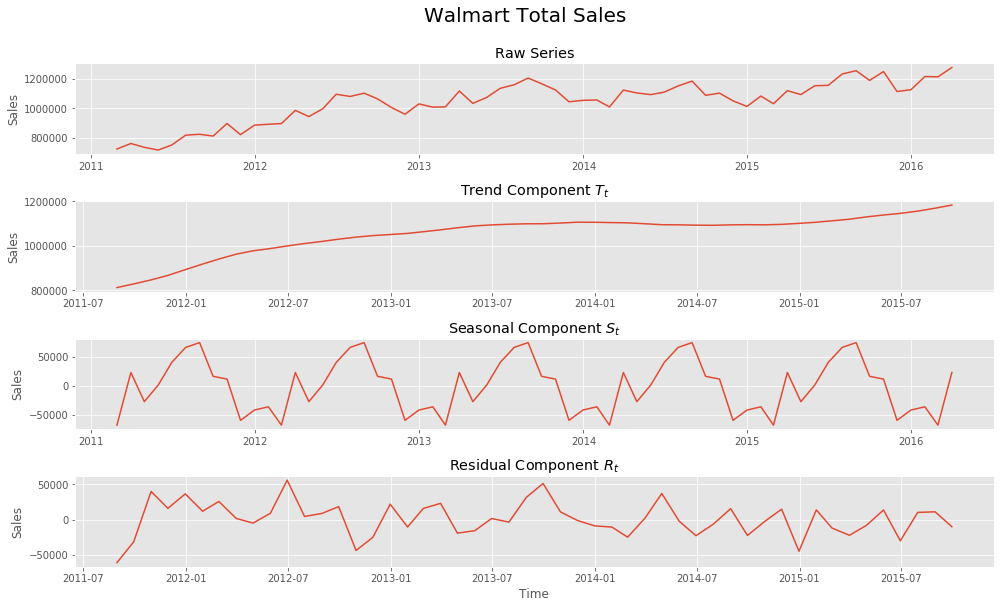

In [29]:
a.TSR()
plt.savefig('../images/big_all_tsr')

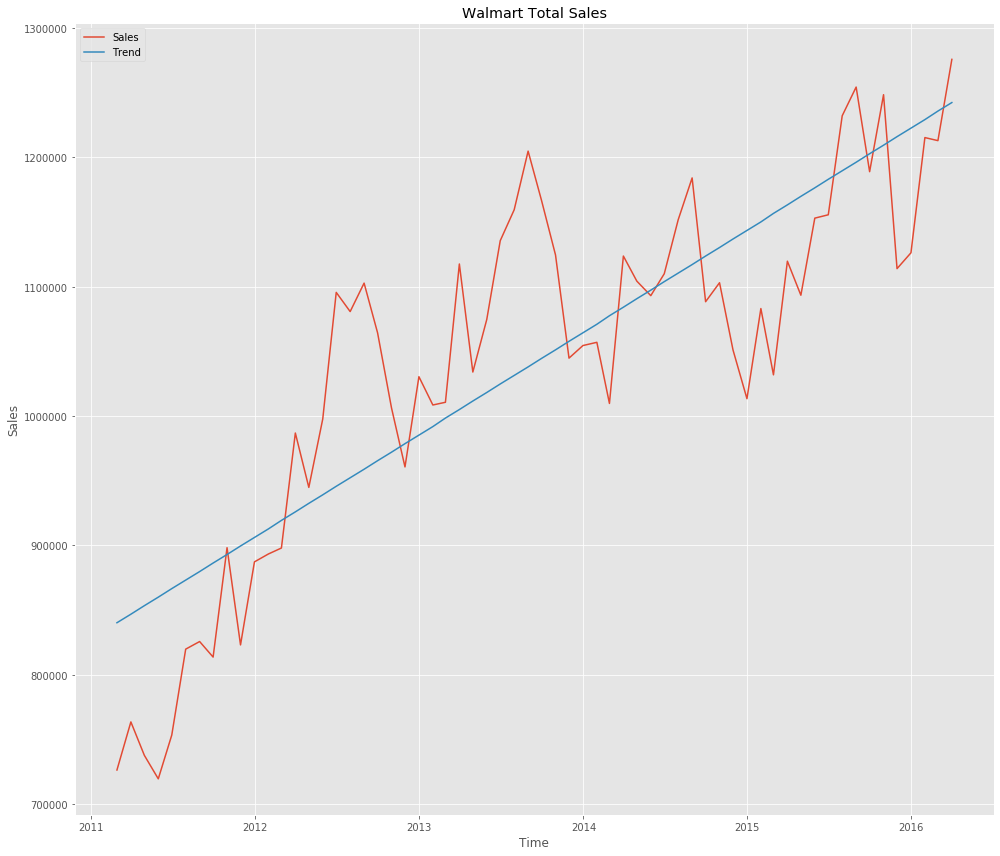

In [30]:
a.linear_trend()
plt.savefig('../images/big_all_lin_trend')

In [28]:
b = graphs(make_series('CA_3', 'FOODS_3'), 'M', 'Walmart CA3 Store Foods3 Department Sales')

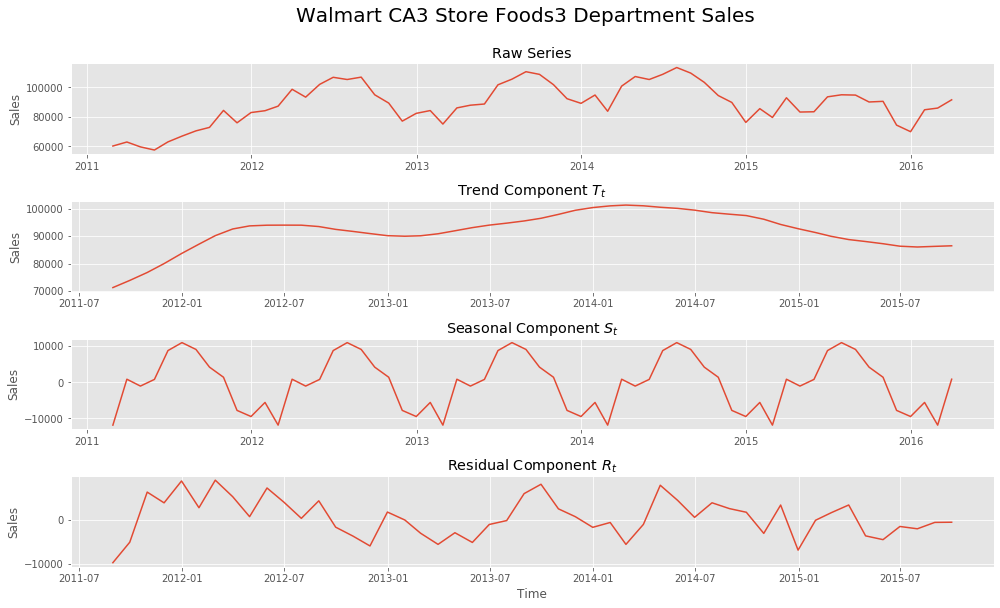

In [29]:
b.TSR()
plt.savefig('../images/ca3_foods3_tsr')

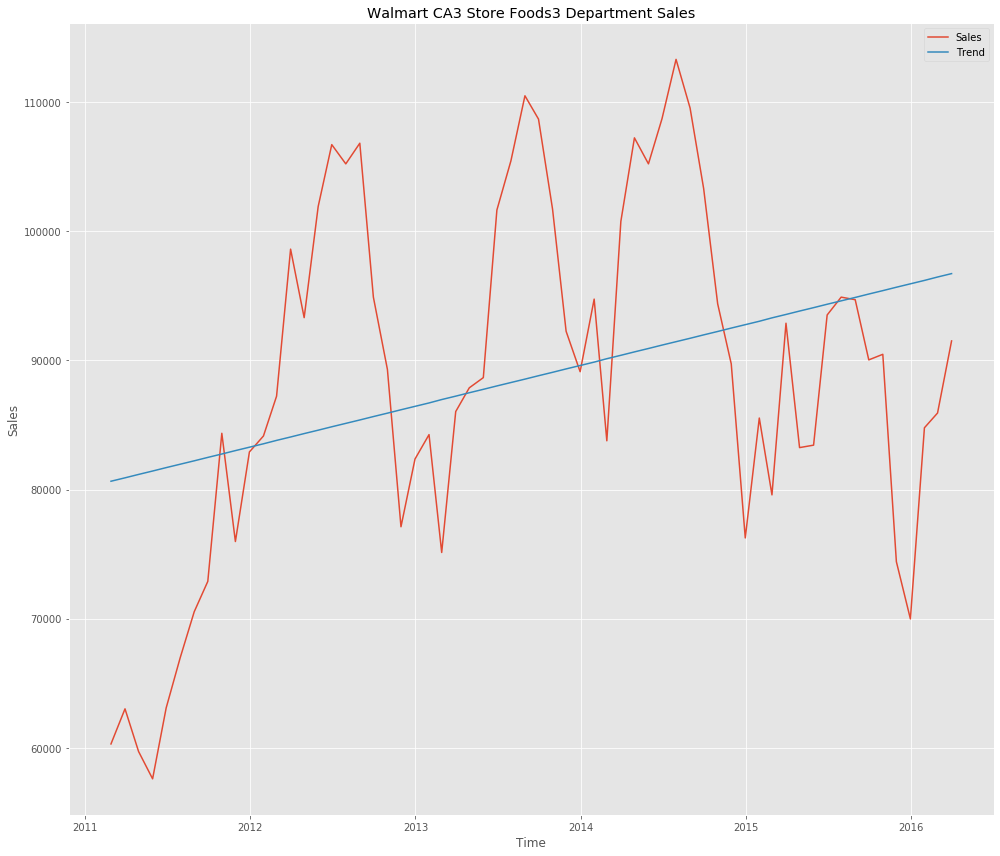

In [30]:
b.linear_trend()
plt.savefig('../images/ca3_foods3_lin_trend')